# <a id='toc1_'></a>[Hiscox Data Science Interview Task: Predicting Insurance Risk](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Hiscox Data Science Interview Task: Predicting Insurance Risk](#toc1_)    
  - [Requirements](#toc1_1_)    
- [Problem Statement - from the task instructions](#toc2_)    
- [Synthesise a mix of numerical, categorical and ordinal features](#toc3_)    
  - [numerical features](#toc3_1_)    
    - [make some features correlated](#toc3_1_1_)    
    - [other features, neglecting any correlation](#toc3_1_2_)    
    - [a few more, with integer values](#toc3_1_3_)    
  - [Categorical features](#toc3_2_)    
    - [multi-category features](#toc3_2_1_)    
    - [similar but for binary categories](#toc3_2_2_)    
  - [Ordinal data](#toc3_3_)    
  - [combine all features](#toc3_4_)    
- [Set a target (claim) variable](#toc4_)    
      - [crime rate](#toc4_1_1_1_)    
      - [flood risk](#toc4_1_1_2_)    
      - [vehicle condition](#toc4_1_1_3_)    
      - [parking location](#toc4_1_1_4_)    
  - [ Categorical features](#toc4_2_)    
  - [create a single, binary claim or no-claim column](#toc4_3_)    
  - [How the relevant features correlate with claims](#toc4_4_)    
- [Dealing with missing values](#toc5_)    
- [Dealing with duplicates](#toc6_)    
- [Make a list of the feature names](#toc7_)    
- [Explore the features](#toc8_)    
  - [Distributions for each feature and pair of features](#toc8_1_)    
- [Prepare data for modelling](#toc9_)    
- [A Random Forest Classifier](#toc10_)    
  - [Feature Selection](#toc10_1_)    
  - [Tune the model](#toc10_2_)    
  - [Retrain model with tuned parameters](#toc10_3_)    
  - [How does the tuned model perform on the test set?](#toc10_4_)    
  - [classification report](#toc10_5_)    
- [Does this model ensure that only 5% of policies make a claim?](#toc11_)    
- [The probability of a policy making a claim](#toc12_)    
- [Model interpretation](#toc13_)    
  - [Basic feature importance](#toc13_1_)    
- [SHAP analysis](#toc14_)    
  - [First generate SHAP values](#toc14_1_)    
  - [SHAP summary plots](#toc14_2_)    
    - [Interpretation of the SHAP summary_plot](#toc14_2_1_)    
      - [crime rate and flood risk](#toc14_2_1_1_)    
      - [vehicle condition](#toc14_2_1_2_)    
      - [parking location](#toc14_2_1_3_)    
      - [neighbourhood watch and CCTV](#toc14_2_1_4_)    
      - [Overall what would we conclude from this plot](#toc14_2_1_5_)    
  - [SHAP decision plots](#toc14_3_)    
    - [Predicted "claim", high probability](#toc14_3_1_)    
    - [Predicted "claim", medium probability](#toc14_3_2_)    
    - [Predicted "no claim", high probability](#toc14_3_3_)    
    - [Predicted "no claim", medium probability](#toc14_3_4_)    
  - [SHAP overall comments](#toc14_4_)    
- [Productionising](#toc15_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Requirements](#toc0_)

In order to run this notebook you need the following python libraries installed in your environment

    numpy
    pandas
    seaborn
    matplotlib
    scipy
    sklearn
    shap

# <a id='toc2_'></a>[Problem Statement - from the task instructions](#toc0_)

We have been approached by the business to use machine learning to determine risk.  There are people that are dubious about the use of modern machine learning techniques over traditional risk quantification methods.  We need to showcase how and why modern machine learning should be adopted, and the modelling approach and outputs should be easily explainable to stakeholders.

The goal of this task is to predict the risk of offering an insurance policy to a potential customer, based on their personal and financial information. The risk is defined as the probability of the customer filing a claim within a year of purchasing the policy. A higher risk means a higher chance of the customer making a claim, which would result in a loss for the insurance company. Therefore, the insurance company wants to understand the risk profile of each customer to determine how to price products.

The business would like to understand how we could use this model to ensure that only 5% of the people they sell a policy to would claim on their policy.

In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import  truncnorm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
RSTATE = 2921
n_samples = 10000

TEST_SIZE = 0.2 # 20% of data will be in the test set
VAL_SIZE = 0.25 # 25% of what is left in the training set, after the test set is 
# selected, will be the validation set
# leaving 60% of the original data as the training set

# <a id='toc3_'></a>[Synthesise a mix of numerical, categorical and ordinal features](#toc0_)

Based on statistics found in various internet searches for typical UK values.

Too many to list sources.

Comments have been added where the feature may need a little more explanation, or the units may not be obvious.

For a real data set we would want all such details included somewhere, e.g in a database.


## <a id='toc3_1_'></a>[numerical features](#toc0_)



### <a id='toc3_1_1_'></a>[make some features correlated](#toc0_)

In reality there would be a lot more correlations between features.

But this is just a synthetic data set designed to demonstrate how a model
works in principle. We do not need to investiagte and include all correlations.

In [132]:
# Define mean, std, min, max for features
numerical_features = {
    'age': {'mean': 45, 'std': 12, 'min': 18, 'max': 85},
    'income': {'mean': 35000, 'std': 15000, 'min': 10000, 'max': 150000},
    'credit score': {'mean': 700, 'std': 50, 'min': 500, 'max': 850},
}

# Define correlation matrix 
# positive correlations between income & credit score, income & age
correlation_matrix = np.array([
    [1.0,  0.5,  0.3],  # Age
    [0.5,  1.0,  0.6],  # Income
    [0.3,  0.6,  1.0],  # Credit Score
])

# generate features
mean_values = np.array([numerical_features[f]['mean'] for f in numerical_features])
std_dev_values = np.array([numerical_features[f]['std'] for f in numerical_features])

# add correlations
L = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition for correlations
np.random.seed(RSTATE)
uncorrelated_data = np.random.normal(0, 1, (n_samples, len(numerical_features))) 
correlated_data = uncorrelated_data @ L.T  # introduce correlation
correlated_data = correlated_data * std_dev_values + mean_values  # scale 

# clip values to min/max limits and save as a dataframe
df_num1 = pd.DataFrame(correlated_data, columns=numerical_features.keys())
for feature in numerical_features:
    df_num1[feature] = np.clip(
        df_num1[feature], numerical_features[feature]['min'], 
        numerical_features[feature]['max'])

df_num1.head()

,age,income,credit score
0,49.087344,59070.906606,782.567449
1,41.336176,62583.098826,708.099578
2,56.057782,13989.835293,629.436625
3,51.096195,42181.322490,697.134233
4,58.780089,37545.345720,682.004761


### <a id='toc3_1_2_'></a>[other features, neglecting any correlation](#toc0_)

Some clearly would be correlated in reality, e.g. house value, number of floors, number of bedrooms etc, also total insured and total for jewelry and electronics.

In [133]:
# define mean, std, min, max for features
numerical_features = {
    'debt': {'mean':1600 , 'std':12250 , 'min':1000 , 'max':50000},
    'time since last claim': {'mean':5 , 'std':2.5 , 'min':0 , 'max':10},
    'house age': {'mean':70 , 'std':50 , 'min':1 , 'max':200},
    'house value': {'mean':290000 , 'std':225000 , 'min':100000 , 'max':1000000},
    'footprint': {'mean':92 , 'std':25 , 'min':50 , 'max':150}, # area of property in m^2
    'total goods': {'mean':35000 , 'std':22500 , 'min':10000 , 'max':100000},
    'total jewelry': {'mean':500 , 'std':4500 , 'min':1000 , 'max':20000},
    'total electronics': {'mean':3000 , 'std':2250 , 'min':500 , 'max':10000},
    'crime rate': {'mean':84 , 'std':9 , 'min':5 , 'max':200}, # per 1000 residents, max is pure guess
    'flood risk': {'mean':0.0105 , 'std':0.0444 , 'min':0.01 , 'max':0.1}, # as probabilities per year, original data was as "1 in N years"
    'population density': {'mean':266 , 'std':1200 , 'min':50 , 'max':5000}, # residents per km^2
    'vehicle age': {'mean':6 , 'std':4 , 'min':0 , 'max':20},
    'annual mileage': {'mean':7000 , 'std':3000 , 'min':3000 , 'max':15000},
}

synthetic_data = {}
rstate_updated = RSTATE
for feature, stats in numerical_features.items():
    mean, std, min_val, max_val = stats['mean'], stats['std'], stats['min'], stats['max']
    a, b = (min_val - mean) / std, (max_val - mean) / std  # lower and upper bounds for standardization
    # generate synthetic values using a truncated normal distribution
    synthetic_data[feature] = truncnorm.rvs(a, b, loc=mean, scale=std, size=n_samples, random_state=rstate_updated)

    rstate_updated += 1
    
df_num2 = pd.DataFrame(synthetic_data)
df_num2.head()

,debt,time since last claim,house age,house value,footprint,total goods,total jewelry,total electronics,crime rate,flood risk,population density,vehicle age,annual mileage
0,15095.242273,7.452094,100.046113,432042.976721,81.362892,29524.131345,1002.704917,4023.570325,85.205816,0.011285,1872.905441,5.774657,6733.364147
1,10482.796188,9.037270,99.432302,452358.128581,94.065502,52265.434689,2290.597641,1105.926986,97.469603,0.065017,2797.047675,3.309299,8744.693186
2,13833.403392,2.636863,81.911751,520399.282469,85.425911,69873.743515,1868.384064,4590.346342,60.707319,0.065955,416.834875,4.050027,9317.237127
3,1527.482307,3.430900,62.747891,642284.923953,83.441440,43318.836956,6870.384732,2733.895972,94.208139,0.050341,651.045053,2.510104,4805.474027
4,43316.911957,3.011114,27.882635,608302.995828,72.452404,19525.928351,1869.993568,9333.015603,71.508659,0.021477,325.547706,6.739274,5096.273215


### <a id='toc3_1_3_'></a>[a few more, with integer values](#toc0_)

In [134]:
# define mean, std, min, max for features
numerical_features = {
    'num_floors': {'mean':2, 'std':0.5, 'min':1, 'max':3},
    'num_bedrooms': {'mean':3, 'std':1.25, 'min':1, 'max':6},
    'num_bathrooms': {'mean':2, 'std':0.75, 'min':1, 'max':4},
    'num_residents': {'mean':2.4, 'std':1.25, 'min':1, 'max':7},
}

synthetic_data = {} 
for feature, stats in numerical_features.items():
    mean, std, min_val, max_val = stats['mean'], stats['std'], stats['min'], stats['max']
    a, b = (min_val - mean) / std, (max_val - mean) / std # lower and upper bounds for standardization
    # generate synthetic values ensuring they are within min - max range
    synthetic_data[feature] = np.round(truncnorm.rvs(a, b, loc=mean, scale=std, size=n_samples, random_state=RSTATE))
    synthetic_data[feature] = np.clip(synthetic_data[feature], min_val, max_val) # clipped incase any now < min or > max
    
df_num3 = pd.DataFrame(synthetic_data)

df_num3.head()

,num_floors,num_bedrooms,num_bathrooms,num_residents
0,2.0,4.0,3.0,3.0
1,2.0,3.0,2.0,3.0
2,2.0,4.0,2.0,3.0
3,1.0,1.0,1.0,1.0
4,3.0,6.0,4.0,6.0


In [135]:
df_num = pd.concat([df_num1, df_num2, df_num3], axis=1)
df_num.head()

,age,income,credit score,debt,time since last claim,house age,house value,footprint,total goods,total jewelry,total electronics,crime rate,flood risk,population density,vehicle age,annual mileage,num_floors,num_bedrooms,num_bathrooms,num_residents
0,49.087344,59070.906606,782.567449,15095.242273,7.452094,100.046113,432042.976721,81.362892,29524.131345,1002.704917,4023.570325,85.205816,0.011285,1872.905441,5.774657,6733.364147,2.0,4.0,3.0,3.0
1,41.336176,62583.098826,708.099578,10482.796188,9.037270,99.432302,452358.128581,94.065502,52265.434689,2290.597641,1105.926986,97.469603,0.065017,2797.047675,3.309299,8744.693186,2.0,3.0,2.0,3.0
2,56.057782,13989.835293,629.436625,13833.403392,2.636863,81.911751,520399.282469,85.425911,69873.743515,1868.384064,4590.346342,60.707319,0.065955,416.834875,4.050027,9317.237127,2.0,4.0,2.0,3.0
3,51.096195,42181.322490,697.134233,1527.482307,3.430900,62.747891,642284.923953,83.441440,43318.836956,6870.384732,2733.895972,94.208139,0.050341,651.045053,2.510104,4805.474027,1.0,1.0,1.0,1.0
4,58.780089,37545.345720,682.004761,43316.911957,3.011114,27.882635,608302.995828,72.452404,19525.928351,1869.993568,9333.015603,71.508659,0.021477,325.547706,6.739274,5096.273215,3.0,6.0,4.0,6.0


In [136]:
df_num.describe()

,age,income,credit score,debt,time since last claim,house age,house value,footprint,total goods,total jewelry,total electronics,crime rate,flood risk,population density,vehicle age,annual mileage,num_floors,num_bedrooms,num_bathrooms,num_residents
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,45.211438,35452.254132,700.595703,11005.140883,5.004477,77.849822,367166.024962,93.788314,40379.560697,4428.317948,3543.045808,83.990192,0.042233,1099.225492,6.607096,7480.614443,2.003300,3.122100,2.12050,2.703000
std,11.789202,14418.378942,50.119239,7445.441904,2.200247,41.893823,167664.184522,21.815017,18151.683281,2617.634969,1826.106172,8.948180,0.022474,763.342796,3.529928,2475.920558,0.527937,1.112077,0.70273,1.060992
min,18.000000,10000.000000,500.000000,1000.317931,0.003761,1.047215,100105.746713,50.004199,10007.302624,1000.514214,500.472350,49.636259,0.010005,50.277437,0.000970,3000.164689,1.000000,1.000000,1.00000,1.000000
25%,37.163627,25165.960919,666.876636,5118.044544,3.409786,45.303531,235255.569589,77.429880,26168.404196,2355.770270,2105.913748,77.906982,0.023381,492.874786,3.936279,5570.149454,2.000000,2.000000,2.00000,2.000000
50%,45.164650,35084.469911,700.396272,9526.142959,5.006745,75.025041,346842.576409,93.169950,38731.326232,3868.613573,3358.433239,83.962944,0.038462,944.592934,6.381210,7333.316746,2.000000,3.000000,2.00000,3.000000
75%,53.287636,45055.581487,734.222248,15341.915580,6.622023,106.112153,476660.184406,109.138551,52331.330684,5929.139118,4783.052331,90.058264,0.057894,1563.747109,8.998347,9135.377755,2.000000,4.000000,3.00000,3.000000
max,85.000000,101658.575966,850.000000,47981.743105,9.999890,199.478061,996527.044572,149.892855,99917.783720,19432.828520,9963.644259,117.243563,0.099980,4824.154549,19.783659,14945.295067,3.000000,6.000000,4.00000,7.000000


In [137]:
len(df_num.columns)

20

## <a id='toc3_2_'></a>[Categorical features](#toc0_)

For the sort of model I am considering we have to convert categorical features to binary, known as "one hot encoding". e.g. instead of having a single column of strings with values 'red','blue','green' we convert to binary columns for is_red, is_blue, is_green, where 1 means True and 0 means False. This converts text categories to numbers.

We do not need to do this if there are only 2 values, those can be represented in one binary column where one value maps to 0 and the other to 1. e.g. if we just had 'red' and 'blue' then a single column could represent red as 1 and blue as 0.

Pandas can do one-hot encoding, it could also be done via sklearn.


### <a id='toc3_2_1_'></a>[multi-category features](#toc0_)

i.e. those with > 2 values

In [138]:
# Define categorical features with probabilities of each category
# i.e. proportion of UK residents / homes / vehicles etc in those categories
multi_categorical_features = {
    'location': ['rural', 'sub-urban', 'urban'],
    'vehicle_type': ['Sedan', 'SUV', 'Van', 'Motorbike'],
    'gender': ['female', 'male', 'other'],
    'construction material': ['brick', 'concrete', 'stone', 'timber']
}

probabilities = {
    'location': [0.17, 0.09, 0.74],  
    'vehicle_type': [0.49, 0.3, 0.2, 0.01], 
    'gender': [0.5025, 0.4875, 0.01],
    'construction material': [0.70, 0.15, 0.10, 0.05]
}

synthetic_data = {}
np.random.seed(RSTATE)
for feature in multi_categorical_features:
    synthetic_data[feature] = np.random.choice(multi_categorical_features[feature], n_samples, p=probabilities[feature])
df_mcat = pd.DataFrame(synthetic_data)
df_mcat = pd.get_dummies(df_mcat) # encode these features

df_mcat.head()


,location_rural,location_sub-urban,location_urban,vehicle_type_Motorbike,vehicle_type_SUV,vehicle_type_Sedan,vehicle_type_Van,gender_female,gender_male,gender_other,construction material_brick,construction material_concrete,construction material_stone,construction material_timber
0,0,0,1,0,1,0,0,0,1,0,1,0,0,0
1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
2,0,0,1,0,0,1,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,1,0,1,0,0,0
4,0,0,1,0,1,0,0,0,1,0,1,0,0,0


### <a id='toc3_2_2_'></a>[similar but for binary categories](#toc0_)

In [139]:
# dictionary of feature name and the probability of that feature occuring
# we can of course infer the probability of it not occuring by subtracting from 1
binary_categorical_features = {
    'married':0.5,
    'smoker': 0.12,
    'chronic health condition':0.41,
    'CCTV': 0.4,
    'smoke alarm': 0.93,
    'burglar alarm': 0.32,
    'neighbourhood watch': 0.32,
}

synthetic_data = {}
np.random.seed(RSTATE)
for feature, prob in binary_categorical_features.items():
    synthetic_data[feature] = np.random.binomial(1, prob, n_samples)

df_bcat = pd.DataFrame(synthetic_data)
df_bcat = pd.get_dummies(df_bcat, drop_first=True) # encode these features

df_bcat.head()

,married,smoker,chronic health condition,CCTV,smoke alarm,burglar alarm,neighbourhood watch
0,1,0,1,0,1,0,0
1,1,0,1,0,0,0,0
2,1,0,0,0,1,0,1
3,0,1,1,0,1,1,0
4,1,0,0,1,1,0,1


In [140]:
df_bcat.describe()

,married,smoker,chronic health condition,CCTV,smoke alarm,burglar alarm,neighbourhood watch
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.502000,0.123300,0.412400,0.399600,0.92700,0.317000,0.319500
std,0.500021,0.328798,0.492291,0.489841,0.26015,0.465331,0.466306
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [141]:
df_cat = pd.concat([df_mcat, df_bcat], axis=1)
df_cat.head()

,location_rural,location_sub-urban,location_urban,vehicle_type_Motorbike,vehicle_type_SUV,vehicle_type_Sedan,vehicle_type_Van,gender_female,gender_male,gender_other,...,construction material_concrete,construction material_stone,construction material_timber,married,smoker,chronic health condition,CCTV,smoke alarm,burglar alarm,neighbourhood watch
0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
3,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,1,0,1,1,0
4,0,0,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,1


In [142]:
len(multi_categorical_features) + len(binary_categorical_features)
# of course we end up with more actual features than this due to the encoding

11

## <a id='toc3_3_'></a>[Ordinal data](#toc0_)

Important that these are in a logical order and numbered. If we use strings then they become catageorical. We could start with strings and convert to integers using sklearn OridanalEncoder, e.g.

    encoder = OrdinalEncoder()
    for column in df_ord.columns:
        df_ord[column] = encoder.fit_transform(df_ord[[column]])

but that seems to be making unecessary work for synthetic data. We can just synthesise ordinal columns with integers representing the relevant aspect of the feature.

I have ordered these so that the lower values correspond to presumed higher risk (if I think there is at least a possible correlation). That is the way most of these were presented in the various sources I found the probabilities in. Of course the model itself will let the data dictate how to use these features. It may find a correlation with claims is the opposite way round to what I assume.

The comments will say what the values correspond to in the following code cell.

In [143]:
ordinal_features = {
    'education level': [0, 1, 2, 3], # GCSES A-level graduate post-graduate
    'employment status': [0, 1, 2, 3], # unemployed part-time full-time self-employed
    # for these first two features I am not assuming lower means higher risk
    # but it stills seems the most logical way round to order them
    'vehicle condition': [0, 1, 2, 3], # poor fair good excellent
    'proximity to emergency services': [0, 1, 2], # far average near
    'parking location': [0, 1, 2], # street drive garage
    'car safety features': [0, 1, 2], # none basic advanced
    'alcohol consumption': [0, 1, 2], # high medium low
    'exercise': [0, 1, 2], # little moderate frequent
    'diet': [0, 1, 2], # poor average healthy
}

# Define probabilities based on internet searches
probabilities = {
    'education level': [0.34, 0.18, 0.34, 0.14],  
    'employment status': [0.10, 0.30, 0.50, 0.10],  
    'vehicle condition': [0.05, 0.25, 0.50, 0.20], 
    'proximity to emergency services': [0.03, 0.27, 0.7],
    'parking location': [0.4, 0.45, 0.15],
    'car safety features': [0.1, 0.5, 0.4],
    'alcohol consumption': [0.02, 0.1, 0.88],
    'exercise': [0.26, 0.11, 0.63],
    'diet': [0.55, 0.35, 0.10]
}

# Generate synthetic ordinal data
synthetic_data = {}
np.random.seed(RSTATE)
for feature in ordinal_features:
    synthetic_data[feature] = np.random.choice(ordinal_features[feature], n_samples, p=probabilities[feature])
df_ord = pd.DataFrame(synthetic_data)

df_ord.head()

,education level,employment status,vehicle condition,proximity to emergency services,parking location,car safety features,alcohol consumption,exercise,diet
0,2,2,2,1,2,1,0,2,1
1,2,2,3,0,2,1,0,2,1
2,2,0,2,2,1,1,2,0,1
3,0,3,3,1,1,2,1,1,0
4,3,2,2,2,0,1,2,2,0


In [144]:
len(df_ord.columns)

9

## <a id='toc3_4_'></a>[combine all features](#toc0_)

In [145]:
data=pd.concat([df_num, df_cat, df_ord], axis=1)
data.head()

,age,income,credit score,debt,time since last claim,house age,house value,footprint,total goods,total jewelry,...,neighbourhood watch,education level,employment status,vehicle condition,proximity to emergency services,parking location,car safety features,alcohol consumption,exercise,diet
0,49.087344,59070.906606,782.567449,15095.242273,7.452094,100.046113,432042.976721,81.362892,29524.131345,1002.704917,...,0,2,2,2,1,2,1,0,2,1
1,41.336176,62583.098826,708.099578,10482.796188,9.037270,99.432302,452358.128581,94.065502,52265.434689,2290.597641,...,0,2,2,3,0,2,1,0,2,1
2,56.057782,13989.835293,629.436625,13833.403392,2.636863,81.911751,520399.282469,85.425911,69873.743515,1868.384064,...,1,2,0,2,2,1,1,2,0,1
3,51.096195,42181.322490,697.134233,1527.482307,3.430900,62.747891,642284.923953,83.441440,43318.836956,6870.384732,...,0,0,3,3,1,1,2,1,1,0
4,58.780089,37545.345720,682.004761,43316.911957,3.011114,27.882635,608302.995828,72.452404,19525.928351,1869.993568,...,1,3,2,2,2,0,1,2,2,0


# <a id='toc4_'></a>[Set a target (claim) variable](#toc0_)

Based on intuition and with bias, so that a model has the oppurtunity to show something meaningful.

This is for a non-specific type of policy, claims may be for the home, contents, car or anything else they could be insured. Lets say about 10% - 15% should have claims, 
i.e. 1000 - 1500 policies. Home and contents claims are around 10%, motor claims around 10 - 15%. Exactly how many claims we end up with does not matter, but it's sensible to make it fairly realistic.

Assign claims based on value of a few selected features. This will result in some policies having multiple claims, and the problem stated is for claim vs no-claim so those will be changed back to just 1 claim.

Initially assign 250 claims each based on 6 different features. This should give us 1500 claims to start with, and after multiple claims per policy have been removed we should end up with a total somewhere between 1000 and 1500.


In [146]:
# this function will also work with ordinal features
def assign_claims_numeric(df: pd.DataFrame, col: str, nclaims: int, scale: float, 
                          new_col: str, random_state: int = 0, bias_to_high: bool=True) -> pd.DataFrame:
    """
    Assign nclaims to a dataframe based on values of a given numerical column.

    Claims are assigned semi-randomly, the higher the value of col the more likely
    that row gets assigned a claim.

    This can work with ordinal features as well.
     
    Parameters
    ----------
    df : pd.DataFrame
        The data frame to add the claims column to
    col : str
        Column influencing the assignment of claims.
    nclaims : int
        Total number of claims to assign.
    scale : float
        Controls probability sensitivity, higher means more biased to high values 
        of df[col]
    new_col : str
        Name of the new, claims, column.
    random_state : int
        Seed for the random numbers.
    bias_to_high : Bool
        Control the bias, by default True and bias is to high values.
    
    Returns
    -------
        Modified DataFrame with new claims columns
    """

    if bias_to_high:
        weights = df[col]**scale
    else:
        weights = (df.max()[col] - df[col])**scale
    
    weights = weights / weights.sum()

    sample = df.sample(n=nclaims, weights=weights, random_state=RSTATE).copy()

    df[new_col] = 0
    df.loc[sample.index, new_col] = 1

    return df

def plot_claims_by_bins(df: pd.DataFrame, claim_col: str, binned_var: str, nbins: int) -> None:
    """ Bar plot showing number of claims per binned value of feature
    
    Parameters
    ----------
    df : pd.DataFrame
        The data frame containing the features and claims
    claim_col : str
        The name of the column with the claims in
    binned_var : str
        The name of the column with the feature we want to plot against
    nbins : int
        The number of bins to use
    """
    min_var = data[binned_var].min()
    max_var = data[binned_var].max()
    bin_width = (max_var - min_var)/nbins
    bin_edges = [min_var + bin_width*i for i in range(nbins)]

    subset = df[df[claim_col] == 1].copy()
    subset['bins'] = pd.cut(subset[binned_var], bins=bin_edges, right=False)
    bin_counts = subset['bins'].value_counts().sort_index()

    bin_counts.plot(kind='bar')
    plt.xlabel(binned_var)
    plt.ylabel('number of claims')
    plt.show()


#### <a id='toc4_1_1_1_'></a>[crime rate](#toc0_)

Seems an obvious choice.

I tried this a few times with different values of the scale argument, plotting the distribution until it gave one that appeared nicely biased to high values but still with some at lower values.

In [147]:
data = assign_claims_numeric(data, 'crime rate', 250, 25, 'claim_1', random_state=RSTATE)    
data['claim_1'].value_counts()

0    9750
1     250
Name: claim_1, dtype: int64

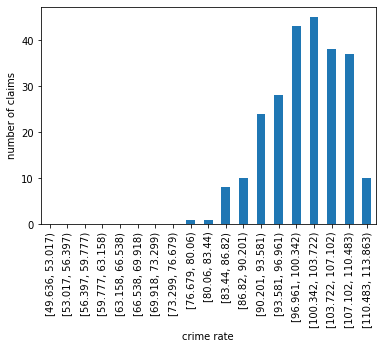

In [148]:
plot_claims_by_bins(data, 'claim_1', 'crime rate', 20)

The shape of the above of course dictated not just by the chance of assigning a claim to a high value of crime rate, but also how many policies there are with such high values. Hence the peak lower than the maximum crime rate.

#### <a id='toc4_1_1_2_'></a>[flood risk](#toc0_)

Another obvious choice, again I tried a few values of scaling.

In [149]:
data = assign_claims_numeric(data, 'flood risk', 250, 15, 'claim_2', random_state=RSTATE)    
data['claim_2'].value_counts()

0    9750
1     250
Name: claim_2, dtype: int64

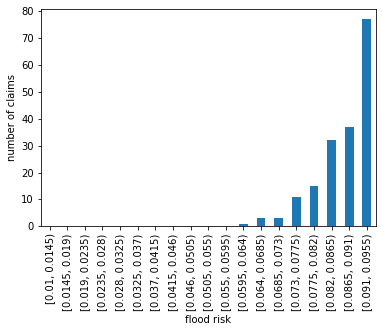

In [150]:
plot_claims_by_bins(data, 'claim_2', 'flood risk', 20)

#### <a id='toc4_1_1_3_'></a>[vehicle condition](#toc0_)

An ordinal feature but we can use the same function to assign claims. Again intuitively seems likely to be a good indicator for motor insurance claims.

Check these by simply counting the number in each category.

In [151]:
data = assign_claims_numeric(data, 'vehicle condition', 250, 9, 'claim_3', bias_to_high=False, random_state=RSTATE)    
data['claim_3'].value_counts()

0    9750
1     250
Name: claim_3, dtype: int64

In [152]:
data[['claim_3','vehicle condition']].groupby('vehicle condition').agg(sum)

,claim_3
vehicle condition,
0,214
1,35
2,1
3,0


#### <a id='toc4_1_1_4_'></a>[parking location](#toc0_)

Another ordinal features, similar logic the previous one.

In [153]:
data = assign_claims_numeric(data, 'parking location', 250, 3, 'claim_4', bias_to_high=False, random_state=RSTATE)    
data['claim_4'].value_counts()

0    9750
1     250
Name: claim_4, dtype: int64

In [154]:
data[['claim_4','parking location']].groupby('parking location').agg(sum)

,claim_4
parking location,
0,221
1,29
2,0


## <a id='toc4_2_'></a>[ Categorical features](#toc0_)

For these I am just picking two where one value of either category ought to make a claim more likely, and if both then even more likely. 
So assign 500 claims to randomly selected rows that have both of these values. 

CCTV and neighbourhood watch

In [155]:
sub_sample = data[(data['CCTV']==0) & (data['neighbourhood watch'])==0].sample(
    n=500, random_state=RSTATE).copy()
data['claim_5'] = 0
data.loc[sub_sample.index, 'claim_5'] = 1
data.claim_5.value_counts()

0    9500
1     500
Name: claim_5, dtype: int64

## <a id='toc4_3_'></a>[create a single, binary claim or no-claim column](#toc0_)

In [156]:
data['claim'] = data.claim_1 + data.claim_2 + data.claim_3 + data.claim_4 + data.claim_5
data['claim'] = data.claim.apply(lambda x: 1 if x >= 1 else 0)
data.drop(columns=['claim_1','claim_2','claim_3','claim_4','claim_5'], inplace=True)
data.head()

,age,income,credit score,debt,time since last claim,house age,house value,footprint,total goods,total jewelry,...,education level,employment status,vehicle condition,proximity to emergency services,parking location,car safety features,alcohol consumption,exercise,diet,claim
0,49.087344,59070.906606,782.567449,15095.242273,7.452094,100.046113,432042.976721,81.362892,29524.131345,1002.704917,...,2,2,2,1,2,1,0,2,1,0
1,41.336176,62583.098826,708.099578,10482.796188,9.037270,99.432302,452358.128581,94.065502,52265.434689,2290.597641,...,2,2,3,0,2,1,0,2,1,0
2,56.057782,13989.835293,629.436625,13833.403392,2.636863,81.911751,520399.282469,85.425911,69873.743515,1868.384064,...,2,0,2,2,1,1,2,0,1,0
3,51.096195,42181.322490,697.134233,1527.482307,3.430900,62.747891,642284.923953,83.441440,43318.836956,6870.384732,...,0,3,3,1,1,2,1,1,0,0
4,58.780089,37545.345720,682.004761,43316.911957,3.011114,27.882635,608302.995828,72.452404,19525.928351,1869.993568,...,3,2,2,2,0,1,2,2,0,0


In [157]:
data.claim.value_counts()

0    8577
1    1423
Name: claim, dtype: int64

About 14% of policies have claims in this synthetic data set.

## <a id='toc4_4_'></a>[How the relevant features correlate with claims](#toc0_)

In [158]:
data[['claim','crime rate','flood risk','vehicle condition','parking location','CCTV','neighbourhood watch']].corr()

,claim,crime rate,flood risk,vehicle condition,parking location,CCTV,neighbourhood watch
claim,1.000000,0.116400,0.121666,-0.133244,-0.050014,0.016578,-0.040914
crime rate,0.116400,1.000000,-0.013884,0.009967,0.008946,-0.007843,0.010189
flood risk,0.121666,-0.013884,1.000000,0.018694,-0.002500,-0.000274,-0.000528
vehicle condition,-0.133244,0.009967,0.018694,1.000000,-0.010072,-0.005843,-0.003802
parking location,-0.050014,0.008946,-0.002500,-0.010072,1.000000,-0.009826,0.004818
CCTV,0.016578,-0.007843,-0.000274,-0.005843,-0.009826,1.000000,0.000997
neighbourhood watch,-0.040914,0.010189,-0.000528,-0.003802,0.004818,0.000997,1.000000


As expected there is small, but clear positive correlation with crime rate and flood risk, and a similar magnetude negative
correlation with vehicle condition. These are lower for the other three features used to assign claims, but their correlations
are still generally higher (only just in the case of CCTV) than those we expect to see for the other features that, in this data set, are not associated with claims,
e.g. see below.

In [160]:
data[['claim','age','house value','num_bedrooms','married']].corr()

,claim,age,house value,num_bedrooms,married
claim,1.000000,0.012926,0.018117,-0.011776,-0.014510
age,0.012926,1.000000,0.007651,0.010864,0.006839
house value,0.018117,0.007651,1.000000,-0.002175,-0.009504
num_bedrooms,-0.011776,0.010864,-0.002175,1.000000,0.758095
married,-0.014510,0.006839,-0.009504,0.758095,1.000000


# <a id='toc5_'></a>[Dealing with missing values](#toc0_)

There are none in this synthetic data set. But with real data we need to deal with these.

This could be done for the whole data set, filling in with mean values for each feature as follows

    data.fillna(data.mean(), inplace=True)
    
Or if we have some other specific default value for a given column, say def_A for column A, we could do 

    data[A].fillna(def_A, inplace=True)

and repeat one column at a time.

Another option is we simply drop rows where there is a missing value

    data.dropna(inplace=True)

If we only want to drop rows where specific columns have missing values

    data.dropna(subset=[col1, col3, col7], inplace=True)

Yet another option is to use sklearn.SimpleImputer to fill in missing values.

My preferred approach is to deal with each feature in the best way for that feature.

If a feature is crucial then drop rows where it is missing.

If the mean or median of the values we have is a sensible fill in value, then use that. Median often better than mean if there are large outliers.

But in some cases we may want to fill in missing values with a default value that we believe
would bias the model towards a preffered default prediction. e.g. if we only want to predict
a claim when we are very sure that is a correct prediction, then our default position should be
values likely to lead to a no-claim prediction. We do not want to bias the model towards 
predicting claims that are not claims just because we filled in missing values that tend
to push the prediction towards a claim.



In [161]:
# check for missing values
print(f'The total number of missing values is {data.isnull().sum().sum()}')

The total number of missing values is 0


# <a id='toc6_'></a>[Dealing with duplicates](#toc0_)

It is extremely unlikely that duplicates would have been generated, but show how to check for them.

In [34]:
print(f'There are {len(data) - len(data.drop_duplicates())} duplicates')

# if there were then simply redefine
# data = data.drop_duplicates()

There are 0 duplicates


# <a id='toc7_'></a>[Make a list of the feature names](#toc0_)

In [35]:
feature_names = data.columns
feature_names = feature_names.drop('claim')
feature_names

Index(['age', 'income', 'credit score', 'debt', 'time since last claim',
       'house age', 'house value', 'footprint', 'total goods', 'total jewelry',
       'total electronics', 'crime rate', 'flood risk', 'population density',
       'vehicle age', 'annual mileage', 'num_floors', 'num_bedrooms',
       'num_bathrooms', 'num_residents', 'location_rural',
       'location_sub-urban', 'location_urban', 'vehicle_type_Motorbike',
       'vehicle_type_SUV', 'vehicle_type_Sedan', 'vehicle_type_Van',
       'gender_female', 'gender_male', 'gender_other',
       'construction material_brick', 'construction material_concrete',
       'construction material_stone', 'construction material_timber',
       'married', 'smoker', 'chronic health condition', 'CCTV', 'smoke alarm',
       'burglar alarm', 'neighbourhood watch', 'education level',
       'employment status', 'vehicle condition',
       'proximity to emergency services', 'parking location',
       'car safety features', 'alcohol consum

# <a id='toc8_'></a>[Explore the features](#toc0_)


## <a id='toc8_1_'></a>[Distributions for each feature and pair of features](#toc0_)


The following shows Nfeatures x Nfeatures subplots, so would be very large and slow to draw if we considered all features. Since we know most features had values assigned at random, below is just an example of those we know are correlated, and a couple of the others that should have no correlations for comparison.

If we saw some features highly correlated with each other, we might consider leaving all but one of those out of the model later.

What we see below shows some degree of correlation for age, income and credit score, but not too much.

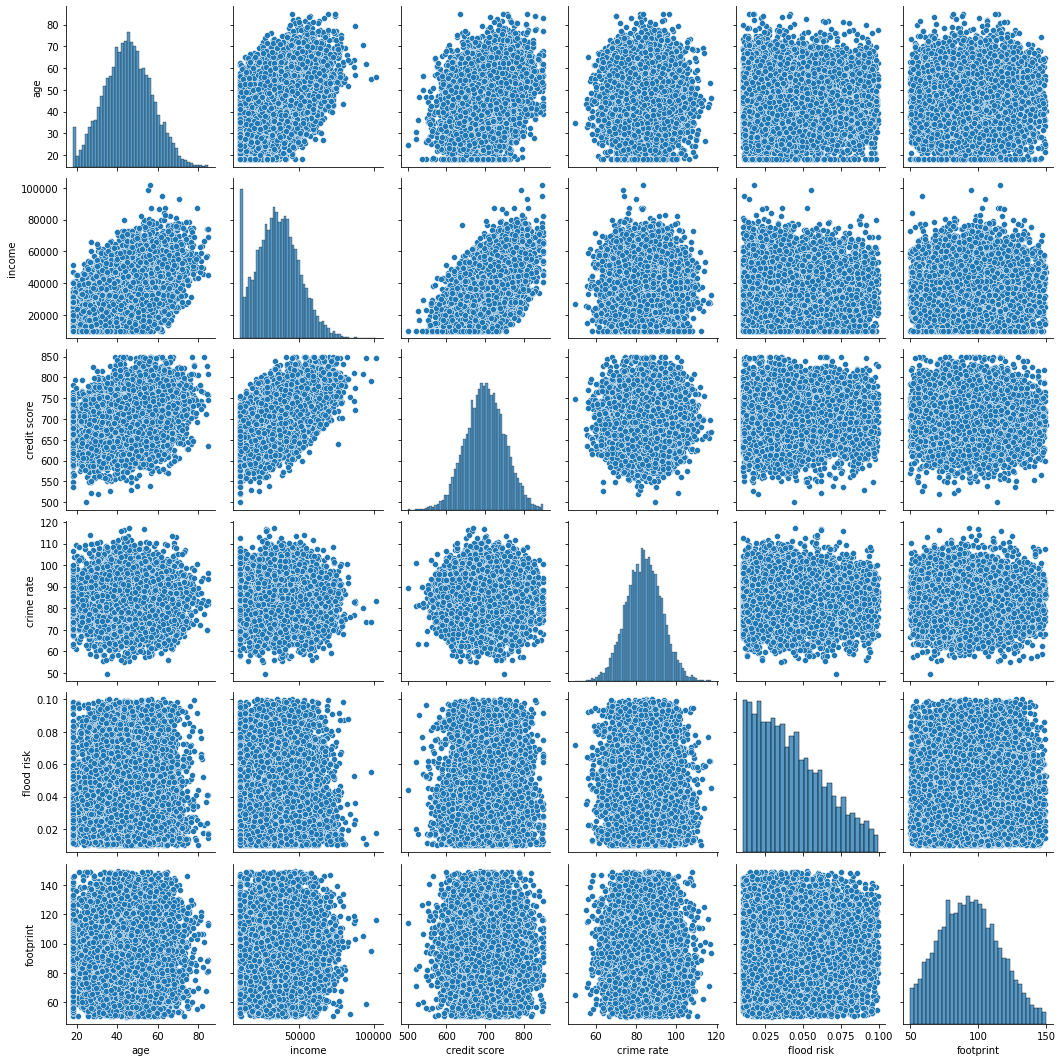

In [36]:
sample_features = ['age', 'income', 'credit score', 'crime rate', 'flood risk', 'footprint']
sns.pairplot(data, vars=sample_features)

# <a id='toc9_'></a>[Prepare data for modelling](#toc0_)

We have already show there are no missing values and no duplicates.

Split into training, validation and test sets.

Using the sizes defined earlier, this should split our 10000 rows into

    2000 for testing
    2000 for validation
    6000 for training

In [37]:
x_train, x_test, y_train, y_test = train_test_split(
    data[feature_names], data['claim'], 
    random_state = RSTATE, test_size=TEST_SIZE)
print(len(x_test))

2000


In [38]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train[feature_names], y_train, 
    random_state = RSTATE, test_size=VAL_SIZE)
print(len(x_val))

2000


In [39]:
print(len(x_train))

6000


# <a id='toc10_'></a>[A Random Forest Classifier](#toc0_)

Random forests are a modern machine learning algorithm that combines the outputs of many single decision tree classifiers.

A decision tree classifier repeatedly splits a dataset based on specific values for a feature. It first splits into two, then each of those subdivisions are split in two, and so on and so on until a subdivision gets splits into two (in the case of a two category classification like this) parts, each of which only contains one class. Once this has been done for all branches, we have a method to predict the class. So we then make a prediction for some unknown data by applying the series of rules the model learned, and seeing which bin we end up in.

A random forest, as its name implies, creates a whole forest of such trees, each using a different random subset of the training data. It also picks features at random to use for the splits. Then a final prediction is made by a majority vote of each of the trees. By using many trees and random subsets and features chosen, these models should be far more robust and less overfit than a single decision tree would be.

They are relatively quick and easy to train and tune. They have fewer hyperparameters than other methods, such as Gradient Boosting Machines which also use decision trees. They are relatively easy to interpret. For example if you want to know not just predictions of which policies have claims, but some measure of probability of having a claim you can look at how many trees predict claim. If we have 100 trees in the forest and 52 predict claim then this is a less probable prediction than if 90 trees predicted claim. Another aspect of them that can be useful is they do not require data to be scaled. So if we were to look at actual values of features in respect to what effect they have in the model, they are in their original units.

Since there are more policies with no claims than with a claim we have imbalanced data.
The class_weight='balanced' argument below makes the algorithm balance the classes using
weights according to the proportion of the two classes in the data. That way in training
the larger class does not bias the algorithm.

I have also set n_jobs = 2, this is as high as my PC goes, but you could increase this on a machine with more cores. However it only takes a couple of seconds to run the next cell.

In [40]:
rf = RandomForestClassifier(random_state=RSTATE, class_weight='balanced',n_jobs=2)
rf.fit(x_train[feature_names], y_train)
train_set_accuracy = accuracy_score(
    y_train,
    rf.predict(x_train)
)
print(f'Random Forest Training set accuracy = {train_set_accuracy:.6f}')

Random Forest Training set accuracy = 1.000000


In [41]:
val_set_accuracy = accuracy_score(
    y_val,
    rf.predict(x_val)
)
print(f'Validation set accuracy = {val_set_accuracy:.6f}')

Validation set accuracy = 0.852000


## <a id='toc10_1_'></a>[Feature Selection](#toc0_)

The model will tell us how important each features was, using a numerical value, higher = more important.

Removing unimportant features and retraining may improve the model.

Normally I would do this with a cross-validated search on the training set, but to save time I will use the validation set here. There are couple of different ways to approach this, removing features one at a time or even considering all possible combinations of features (if there are not many to start with).

But for this model I will just retrain with the least important features removed and see if that improves performance on the validation set.

In [42]:
fdf = pd.DataFrame({
    'features': feature_names,
    'importance': rf.feature_importances_
}) 

fdf.sort_values('importance')

,features,importance
29,gender_other,0.000536
23,vehicle_type_Motorbike,0.000781
20,location_rural,0.002442
38,smoke alarm,0.002532
34,married,0.002619
21,location_sub-urban,0.002736
22,location_urban,0.003023
35,smoker,0.003121
32,construction material_stone,0.003458
33,construction material_timber,0.003542


Arbitrary choice, just as an example, try removing features where importance < 0.005.

That leaves the CCTV feature in, which, since this is synthetic data, we know might be useful.

In [43]:
reduced_features = fdf[fdf.importance >= 0.005].features
print(len(reduced_features))

32


In [44]:
### train a model with reduced features
rf_red = RandomForestClassifier( 
    class_weight='balanced',n_jobs=2, random_state=RSTATE
    )
rf_red.fit(x_train[reduced_features], y_train)
train_set_accuracy = accuracy_score(
    y_train,
    rf_red.predict(x_train[reduced_features])
)
print(f'Random Forest Training set accuracy = {train_set_accuracy:.6f}')

Random Forest Training set accuracy = 1.000000


In [45]:
val_set_accuracy = accuracy_score(
    y_val,
    rf.predict(x_val)
)
print(f'Original Validation set accuracy = {val_set_accuracy:.6f}')

val_set_accuracy = accuracy_score(
    y_val,
    rf_red.predict(x_val[reduced_features])
)
print(f'After feature selection, Validation set accuracy = {val_set_accuracy:.6f}')

Original Validation set accuracy = 0.852000
After feature selection, Validation set accuracy = 0.850500


This has not improved the performance on the validation set.

Therefore stick with the original, all features model.

This was a very simplified approach. A better way is removing one feature at a time and retraining. Lets say features X, Y and Z have the lowest importance in the default model and we then remove Z. It does not automatically follow that Y is now the least important feature, that might now be X. The model without Z might find something more useful to do with Y and have less use for X. Therefore simply removing all features with importance below a threshold, or even removing one at a time without re-training, may not improve the model, as we have seen here.

## <a id='toc10_2_'></a>[Tune the model](#toc0_)

Every machine learning model has tuneable hyperparameters. Here we use the validation set to assess the best values for these, this can reduce overfitting, i.e. ensuring the model is more robust and works well not just on the training set but also on other data.

Normally I would do this cross-validated on the training set making use of the  sklearn classes GridSearchCV and RandomizedSearchCV. But that could take a lot of time. So here I am keeping things simple.

Also for simplicity here I will only consider two hyperparameters

    n_estimators : the number of trees in the forest

    max_depth : how big we allow the trees to grow

In practice others might be tuned as well, but in my experience these are the most important two.


In [46]:
# The full set of hyper-parameters
rf.get_params()
# Note max_depth: None means that by default there is no restriction on this

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': 2921,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Define parameter values to assess
n_estimators_list = [75, 100, 125, 150]
max_depth_list = [5, 10, 15, None]

best_params = None
best_accuracy = 0

# first show how the default model performs
y_pred = rf.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Default random forest, 100 trees, no max_depth, validation set accuracy: {accuracy:.4f}')

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced',n_jobs=2, random_state=RSTATE)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_val)
        accuracy = accuracy_score(y_val, y_pred)

        print(f'n_estimators={n_estimators}, max_depth={max_depth}, validation set accuracy: {accuracy:.4f}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (n_estimators, max_depth)

print("\nBest Parameters:", best_params)


Default random forest, 100 trees, no max_depth, validation set accuracy: 0.8520
n_estimators=75, max_depth=5, validation set accuracy: 0.8270
n_estimators=75, max_depth=10, validation set accuracy: 0.8490
n_estimators=75, max_depth=15, validation set accuracy: 0.8530
n_estimators=75, max_depth=None, validation set accuracy: 0.8530
n_estimators=100, max_depth=5, validation set accuracy: 0.8265
n_estimators=100, max_depth=10, validation set accuracy: 0.8490
n_estimators=100, max_depth=15, validation set accuracy: 0.8535
n_estimators=100, max_depth=None, validation set accuracy: 0.8520
n_estimators=125, max_depth=5, validation set accuracy: 0.8290
n_estimators=125, max_depth=10, validation set accuracy: 0.8510
n_estimators=125, max_depth=15, validation set accuracy: 0.8535
n_estimators=125, max_depth=None, validation set accuracy: 0.8505
n_estimators=150, max_depth=5, validation set accuracy: 0.8265
n_estimators=150, max_depth=10, validation set accuracy: 0.8525
n_estimators=150, max_dept

This was just a quick demonstration of how we can tune a model.

Using the above values of hyperparamters we have improved the predictions on the validation set from

0.8520 to 0.8535

It's not much, but for a real model this tuning would usually be a much bigger, far more time consuming, task.


## <a id='toc10_3_'></a>[Retrain model with tuned parameters](#toc0_)

In [48]:
rf_tuned = RandomForestClassifier(
    n_estimators=best_params[0], 
    max_depth=best_params[1], 
    class_weight='balanced',n_jobs=2, random_state=RSTATE
    )
rf_tuned.fit(x_train, y_train)
print(f'Random Forest Training set accuracy = {train_set_accuracy:.6f}')

Random Forest Training set accuracy = 1.000000


## <a id='toc10_4_'></a>[How does the tuned model perform on the test set?](#toc0_)

Note the test set (sometimes called a hold out set) has been used neither for training, nor validation. It is completely independent of those, so gives us a performance metric that cannot be biased to any data used in building the model.

In [49]:
y_pred = rf_tuned.predict(x_test)
test_set_accuracy = accuracy_score(y_test,y_pred)
print(f'Test set accuracy = {test_set_accuracy:.6f}')

Test set accuracy = 0.860000


## <a id='toc10_5_'></a>[classification report](#toc0_)

I have used the accuracy metric (proportion of correct predictions) so far. 

The following report shows more metrics and also broken down by the two classes

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92      1716
           1       0.54      0.09      0.16       284

    accuracy                           0.86      2000
   macro avg       0.70      0.54      0.54      2000
weighted avg       0.82      0.86      0.81      2000



The model has a very high recall for the 0 (no claims) class, 0.99. This means that
99% of the policies with no claims, in the test set, are correctly predicted. However for the 1 (claims) class only 9% are correctly predicted. The precision values show what proportion of those predicted in each class are correctly predicted. The 87% for the no claims is a little low, and the 54% for the claims class would be very disappointing - if this were a finished model on a real data set. But this is neither of those, just a proof-of-concept task. The f1-score is based on a combination of precision and recall, so gives a more balanced view of how the model is working. 

# <a id='toc11_'></a>[Does this model ensure that only 5% of policies make a claim?](#toc0_)

As specified as the business need in insructions for this assessment.

In [51]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('If we used this model then we would')
print(f'predict {tn+fn} policies as not going to make a claim')
print(f'of which {fn} actually would make a claim, i.e. {100*fn/(fn+tn):.2f}%')
print(f'We would also wrongly predict {fp} policies would make a claim.')

If we used this model then we would
predict 1952 policies as not going to make a claim
of which 258 actually would make a claim, i.e. 13.22%
We would also wrongly predict 22 policies would make a claim.


This model therefore does not achieve the requirement of providing a way to  ensure only 5% of policies would make a claim. In this case if policies were only offered to those predicted to make no-claim then 13.22% would make a claim.

However the point of this exercise is to demonstrate the concept. A synthetic data set has been used where only 6 of the original 40 features have been generated with any intrinsic correlation with claims.

On a real data set where all features might correlate with claims, either on their own or when interactions with other features are taken into account, plus with proper tuning and feature selection, it can hopefully be seen how a better model could reduce that 13.22% to an acceptable level.

# <a id='toc12_'></a>[The probability of a policy making a claim](#toc0_)

We can use the model to give us a probability for a prediction of claim. All the policies in the test set have this, even those predicted as no-claim. For a random forest classifier this is the fraction of trees that predict a claim. 

In [52]:
test_predictions = pd.DataFrame({
    'Observed': y_test,
    'Predicted': y_pred,
    'Probability': rf_tuned.predict_proba(x_test)[:,1]
})
test_predictions.sort_values('Probability', ascending=False).head()

,Observed,Predicted,Probability
8701,1,1,0.703666
1216,1,1,0.661507
8319,1,1,0.661224
987,1,1,0.660165
1398,0,1,0.649712


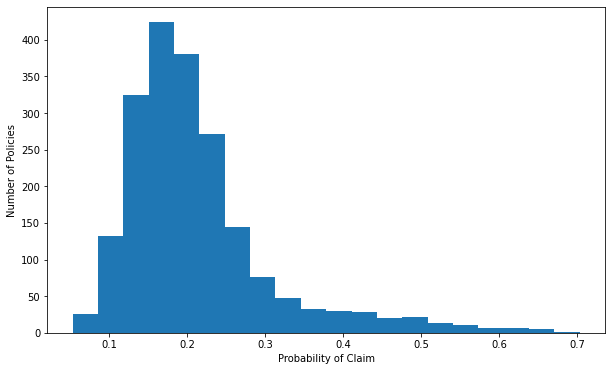

In [53]:
plt.figure(figsize=(10,6))
plt.hist(test_predictions.Probability, bins=20)
plt.xlabel('Probability of Claim')
plt.ylabel('Number of Policies')
plt.show()

The above chart shows the distribution of probabilities that a policy makes a claim, according to this model. If probability of claim > 0.5 then the model classifies this as a predicted claim.

# <a id='toc13_'></a>[Model interpretation](#toc0_)

## <a id='toc13_1_'></a>[Basic feature importance](#toc0_)

First we look at the feature importance mentioned earlier, plotting them below. Higher values mean the feature is more important. It is a measure of how strong a role a feature has in making the predictions.

This is quite a basic measure of importance and is not that informative. 

It suggests the most important features are 

    flood risk
    crime rate
    vehicle condition

Since this is synthetic data, we know that all of these influenced whether a claim was assigned to a policy or not. So it makes sense that they are seen as important.  However the other three such features
    
    parking location
    neighbourhood watch
    CCTV

all have lower, some much lower, importance.

A Random Forest model may well find a way to predict claims on the training set using features other than those we made correlated with claims. Let us suppose that by pure chance there is a group of policies in the training set with claims that all happen to have high vehicle age, low house value and low footprint. The model could find that, even though we did not intentionally put such a relationship there. But if it does find such a chance relationship in the training set, it is unlikely to be found in the test set as well, and so could explain the relatively poor performance of the model on the test set. In any case just looking at the relative importance of features in the model is not enough to explain how the model is working. We need a more detailed approach, and that is covered next.





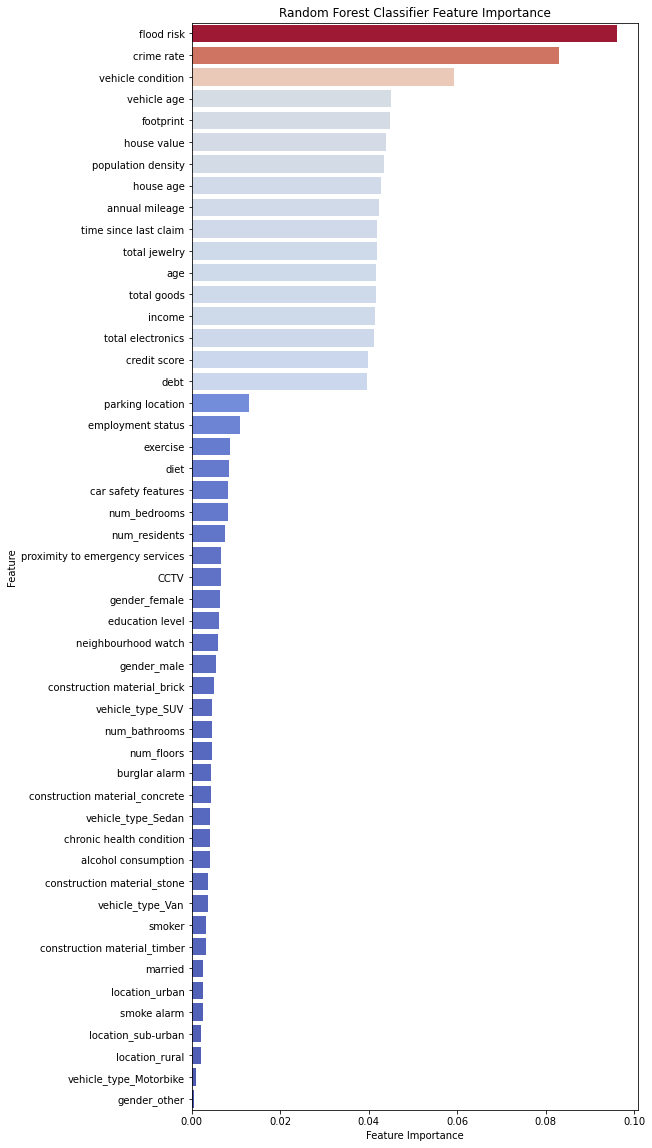

In [55]:
importances = pd.DataFrame({'Feature': feature_names, 'Importance': rf_tuned.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 20))
sns.barplot(x='Importance', y='Feature', data=importances, palette='coolwarm', 
            orient='h', order=importances['Feature'],
            hue='Importance', legend=False)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Classifier Feature Importance')
plt.show()

# <a id='toc14_'></a>[SHAP analysis](#toc0_)

This carries out a more detailed analysis of the importance of each feature and how the model makes the predictions it does. So this, or another similar type of analysis, is very important in interpreting the model. It can show things the previous basic feature_importance plot misses.

SHAP stands for SHapley Additive exPlanations and draws on concepts from game theory. It also generates feature importances but does this by considering all possible combinations of features. It can give both global (whole data set) and local (individual prediction) explanations. There are various types of plot SHAP can generate. Two types are shown below. One for a global view and then some specific example policies. 

## <a id='toc14_1_'></a>[First generate SHAP values](#toc0_)

This can be a slow process, but on this data set should take under a minute.

On larger data sets though, we might have to restrict analysis to a subset of our data.

In [56]:
shap.initjs()
explainer = shap.Explainer(rf_tuned)
shap_values = explainer.shap_values(x_test)

## <a id='toc14_2_'></a>[SHAP summary plots](#toc0_)

To give an overall picture of feature importance

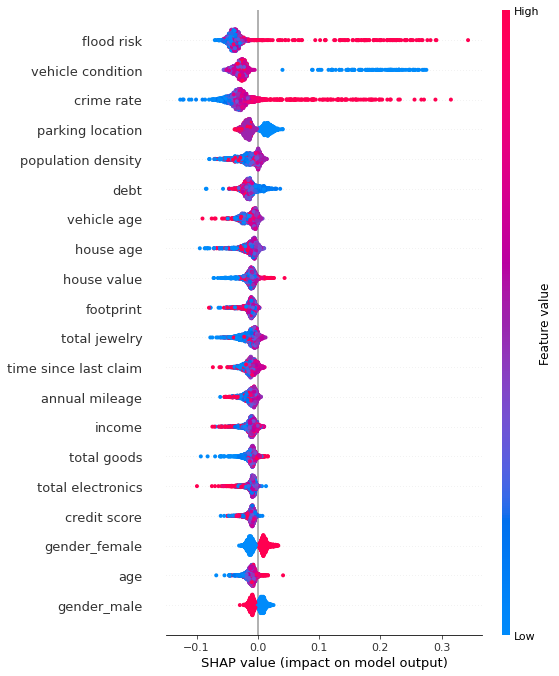

In [57]:
shap.summary_plot(shap_values[1], x_test)
# shap_values[1] means those influence the prediction of class 1, i.e. claims in this case

### <a id='toc14_2_1_'></a>[Interpretation of the SHAP summary_plot](#toc0_)

This resembles the earlier basic feature importance plot, but with more information. The features are ordered from most important at the top to least at the bottom, but it only shows the most important features, automatically filtering out those it sees as having no meaningful effect. 

Blue dots correspond to low values of the feature and red to high. The x-axis is the SHAP value, how much this features influences the predictions of this class. The wider the spread of dots along the x-axis, the greater this feature's influence on the predictions. Each dot corresponds to a different data point and those with the same value are spread out along the y-axis to show that. If we see mainly red dots on the positive side of the x-axis that mean high values of this feature push the prediction towards a claim - and that is what we see in most cases. If we see mainly blue on the positive side then low values of that feature are pushing the prediction towards a claim.

#### <a id='toc14_2_1_1_'></a>[crime rate and flood risk](#toc0_)
These both have mainly red dots on the positive side of the x-axis, so high values of these tend to lead to a claim being predicted. They cover a wide range of SHAP values, indicating their relative high importance 

#### <a id='toc14_2_1_2_'></a>[vehicle condition](#toc0_)
We can see a number of blue dots with significant positive SHAP values, i.e. low values of vehicle condition are leading to predictions of a claim. This too covers a wide range of SHAP values, indicating its high relative importance.

#### <a id='toc14_2_1_3_'></a>[parking location](#toc0_)
We see a similar pattern to that for vehicle condition; low values lead to predictions of claim. But the SHAP values are focussed on a much narrower range, so the importance is lower than for the previous three features.


The above all makes sense given that we know the data was synthesized with a claim more likely for high crime rate, high flood risk, low vehicle condition and low parking location.

We can also see some bias towards high or low values for some other features leading to predictions of claim, but they are all of lower importance to the above features.

#### <a id='toc14_2_1_4_'></a>[neighbourhood watch and CCTV](#toc0_)
Neither appear on the plot, so they were both found to be not important in terms of SHAP analysis, even though we did assign some claims according to low values of both of these. In hindsight it probably is no surprise these are not important. Although claims were set when both these binary features were 0, those made up about 60% of the data, so the large majority of policies with 0 values for these two features have no claim. I had hoped the model might pick up on a weak relationship towards both these features being 0, but it appears it has not.

#### <a id='toc14_2_1_5_'></a>[Overall what would we conclude from this plot](#toc0_)
If we knew nothing of the way the data was synthesized, we would conclude that high crime rate, high flood risk and low vehicle condition were the most important factors when it came to predicting a claim, in this model, with low (i.e. on street) parking location having a small contribution too.

## <a id='toc14_3_'></a>[SHAP decision plots](#toc0_)

To look at specific examples.

These show the features on the y-axis that were most important in that specific data's prediction, again most important at the top. A line is plotted from bottom to top, moving left and right along the x-axis as each feature contributes to either a prediction of claim (moving the right) or no claim (moving to the left). If the line ends up, at the top, > 0.5 then it is predicted a claim.

In [58]:
# add a row number column to the test_predictions data frame
# so we know the order of these in the test set and can access
# individual rows in the SHAP values knowing what predictions they had
test_predictions['row'] = [i for i in range(len(test_predictions))]
test_predictions.sort_values('Probability', ascending=False, inplace=True)
test_predictions.head()

,Observed,Predicted,Probability,row
8701,1,1,0.703666,669
1216,1,1,0.661507,1674
8319,1,1,0.661224,698
987,1,1,0.660165,1644
1398,0,1,0.649712,869


In [63]:
test_predictions[(test_predictions.Predicted == 1) & (test_predictions.Probability < 0.6)].head()

,Observed,Predicted,Probability,row
3641,1,1,0.597435,1496
6295,0,1,0.594138,121
8905,0,1,0.593003,1559
4873,0,1,0.580974,4
4030,0,1,0.580941,409


In [67]:
test_predictions.tail()

,Observed,Predicted,Probability,row
7240,0,0,0.068541,1617
2649,0,0,0.063267,894
5960,0,0,0.057923,1019
3937,0,0,0.054052,1756
651,0,0,0.053167,1928


In [68]:
test_predictions[(test_predictions.Predicted == 0) & (test_predictions.Probability > 0.25)].tail()

,Observed,Predicted,Probability,row
4864,0,0,0.250808,502
1040,1,0,0.250543,337
5003,0,0,0.250356,609
5043,0,0,0.250263,1921
3148,0,0,0.250015,400


Using the above, pick out a couple of examples to see how the model reached it's prediction. 

Show one example each for strong and moderate prediction of claim(1) or no-claim(0)

### <a id='toc14_3_1_'></a>[Predicted "claim", high probability](#toc0_)

The plot below shows that after the contributions from most features the probability was just below 0.5 (bottom of the plot). As more important features add their contributions the prediction moves reasonably steadily towards no-claim and it is only when the most important feature for this policy, flood risk, is included that the prediction changes to claim.

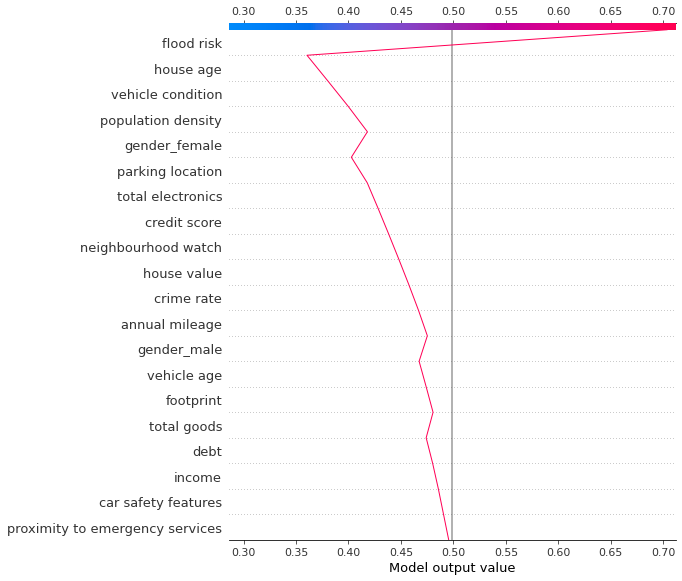

In [62]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][669,:], x_test.columns)

### <a id='toc14_3_2_'></a>[Predicted "claim", medium probability](#toc0_)

Again the less important features leave this policy around 0.5 probability. As the more important are added in then the prediction moves towards no-claim, but with a few features making small change in direction. And it is the most important feature, vehicle condition, that changes the prediction from no-claim to claim.

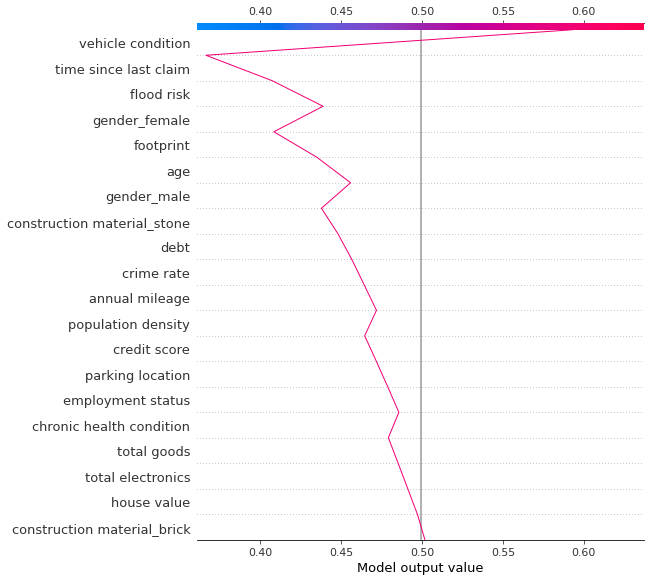

In [66]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][1559,:], x_test.columns)

### <a id='toc14_3_3_'></a>[Predicted "no claim", high probability](#toc0_)

i.e. high "probability of no claim", since actual probability value is very low.

In this case we see that all important features pushed this prediction towards no-claim. If this were real data and a better model we could be very confident in this policy not making a claim and see that prediction was a result of many different features adding small but consistent contributions to that prediction.

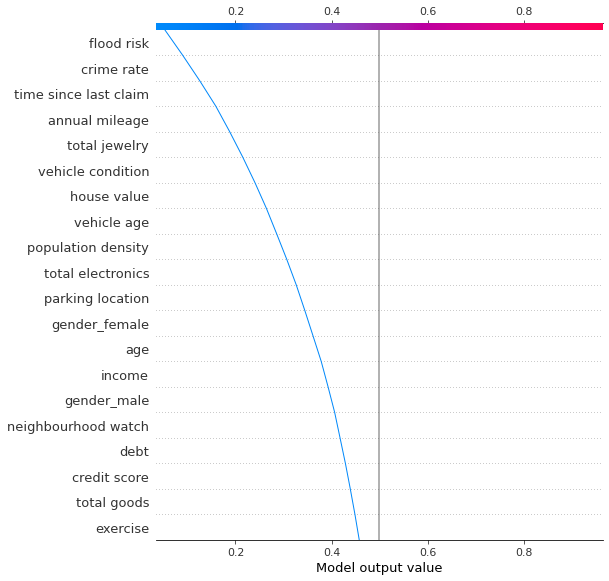

In [69]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][1928,:], x_test.columns)

### <a id='toc14_3_4_'></a>[Predicted "no claim", medium probability](#toc0_)

This one is similar to the previous, except the cumulative effect of the most important features pushes this less towards no-claim, and a couple of important features actually pushes this slightly towards claim, but not enough to overturn the effect of all the other features.

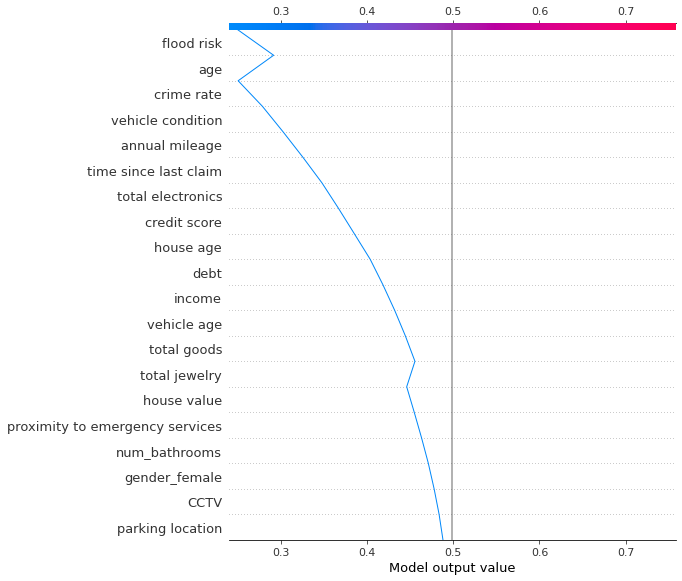

In [72]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][609,:], x_test.columns)

## <a id='toc14_4_'></a>[SHAP overall comments](#toc0_)

This is just a taste of what SHAP can do to help interpret models. But it shows a more meaningful picture of feature importance globally than that we had initially, and that we can also look in detail at how individual data is predicted, so that we can explain the predictions.

# <a id='toc15_'></a>[Productionising](#toc0_)

Assuming the business likes your model, what are the next steps to go from a Jupyter Notebook to a productionised service?

    What are the considerations for ensuring the business can leverage it?

    What are the steps you would take to provide this to the business?

    Which traditional teams in a business would you need to speak to?
    
    What is in scope and out of scope for your responsibility?


First of all a model needs to be trained, tuned and tested on real data.

The model needs to be saved so that it can be deployed in an appropriate environment, where it, or some other stage in a pipeline, can access the data used to construct the features for real policies.  A model can be saved in various formats, e.g. joblib or pickle, and then read back into a script that applies it to other data. We would want other code that generates the features, assuming they are not all in a useable format in a database already. e.g. code that turns categorical features into binary features, checks for missing values and duplicates and deals with them appropriately, and although not used here, for other types of algorithm features require scaling. 

I think more work validating the model on other data sets would be good, checking it's performance is maintained on data not used in development. For example if the model were trained on data from all existing policy holders we might want to check for any subsets of customers it might not work as well on, e.g. sub-grouped by location, new vs well established customers etc. 

I would want to consult teams such as Actuarial and Engineering. The former, I assume, could be those stakeholders who may need convincing of the use of modern machine learning. The latter need to understand what the model is going to do in practice, so they can use their expertise in identifying any potential problems running this model day-to-day. Any big change in ways of working, and switching from a traditional pricing model to a modern ML model is a big change, also clearly needs to be demonstrated to senior management, for their approval.

Models change over time, new data comes in, new features might become available, customer profiles change, and therefore the best model now may not be the best in the future. We need set up some form of tracking and versioning, e.g. using an MLOps system like MLflow, so as new versions of the model are developed and experimented with we keep track of versions and performance. It would also be good to check the model performance at regular intervals, retrospectively to see how many claims it predicted compared to how many there actually where. By monitoring performance we can see if and when the model needs retraining. Again MLflow could be used to track such retrospective experiments.

All of the above I see as within scope for Data Science.

It might be nice to create some sort of demo-dashboard that non-technical people can easily use to see what sort of predictions the model makes on example data. This might be outside of scope for Data Science. It depends how complex this would be, who exactly the end user of this is, etc.

Other teams responsibility would probably include the actual deployment of the model, for engineers to do, similarly considerations of scalability, security and access to data. The model needs testing in an environment similar to production, before deploying there, by (I assume) a QA team. I am envisioning this model, or something similar, could eventually be providing quotes to potential customers on a website, so some sort of web interface that has access to the model is for another teams to do. But these all probably need at least some Data Science input at least to advise, provide test cases, etc.